In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sberav.splits.tests import ClassifierTwoSampleTestBootstrap, KolmogorovSmirnovTwoSamplesTest

import pickle

## Очистка данных

In [2]:
data_path = "../../data/preprocessed/"  # features_with_target.csv

transaction_features = pd.read_csv(data_path + "x5_transaction_features.csv", index_col="client_id")
client_features = pd.read_csv(data_path + "x5_client_features.csv", index_col="client_id")
df_target = pd.read_csv("../../data/datasets/x5-retail-hero/uplift_train.csv.gz", index_col="client_id")
df = transaction_features.join(client_features).join(df_target)
df = df[df.age > 0]
df = df[df.age < 110]
df

,regular_points_received_mean,regular_points_received_std,regular_points_received_median,regular_points_received_max,regular_points_received_skew,express_points_received_mean,express_points_received_std,express_points_received_median,express_points_received_max,express_points_received_skew,...,percent_of_transactions_in_12_month,age,first_issue_time,first_redeem_time,issue_redeem_delay,F,M,U,treatment_flg,target
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,6.425000,2.973529,6.85,10.0,-0.355890,0.000,0.000000,0.0,0.0,0.000000,...,2,45,0.336675,0.735365,0.398690,0,0,1,0,1
000036f903,1.715625,1.461401,1.30,7.0,2.367965,1.875,10.439558,0.0,60.0,5.388159,...,10,72,0.015925,0.033211,0.017286,1,0,0,1,1
00010925a5,1.766667,1.139688,1.45,5.8,2.321282,0.000,0.000000,0.0,0.0,0.000000,...,6,83,1.303876,1.428140,0.124264,0,0,1,1,1
0001f552b0,5.260000,9.686334,1.60,39.7,2.953750,0.000,0.000000,0.0,0.0,0.000000,...,4,33,0.238463,1.381198,1.142734,1,0,0,1,1
00020e7b18,15.894444,13.081389,14.60,44.5,0.819229,0.000,0.000000,0.0,0.0,0.000000,...,2,73,0.648549,0.751613,0.103064,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,2.466667,3.003701,0.70,7.3,0.703218,0.000,0.000000,0.0,0.0,0.000000,...,1,35,0.648236,0.838325,0.190090,1,0,0,0,0
fffe0ed719,2.330000,2.281542,1.50,8.6,1.531437,0.000,0.000000,0.0,0.0,0.000000,...,4,69,0.448229,0.671819,0.223590,0,0,1,0,1
fffea1204c,1.535294,1.710845,0.90,5.9,1.563107,0.000,0.000000,0.0,0.0,0.000000,...,4,73,0.827236,0.918646,0.091409,1,0,0,0,1


In [34]:
df.columns

Index(['regular_points_received_mean', 'regular_points_received_std',
       'regular_points_received_median', 'regular_points_received_max',
       'regular_points_received_skew', 'express_points_received_mean',
       'express_points_received_std', 'express_points_received_median',
       'express_points_received_max', 'express_points_received_skew',
       'regular_points_spent_mean', 'regular_points_spent_std',
       'regular_points_spent_median', 'regular_points_spent_max',
       'regular_points_spent_skew', 'express_points_spent_mean',
       'express_points_spent_std', 'express_points_spent_median',
       'express_points_spent_max', 'express_points_spent_skew',
       'purchase_sum_mean', 'purchase_sum_std', 'purchase_sum_median',
       'purchase_sum_max', 'purchase_sum_skew',
       'percent_of_transactions_in_0_day', 'percent_of_transactions_in_1_day',
       'percent_of_transactions_in_2_day', 'percent_of_transactions_in_3_day',
       'percent_of_transactions_in_4_day', 

## Matplotlib settings

In [4]:
plt.style.use('default')

rc = {
    'text.usetex': True,
    'font.size': 12,
    'legend.fontsize': 10,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 5.0,
    'xtick.minor.size': 3.0,
    'ytick.major.size': 5.0,
    'ytick.minor.size': 3.0,
    # 'axes.linewidth': 3.0,
    'legend.handlelength': 5.0,
    'legend.markerscale': 0.5,
    'text.latex.preamble': "\\usepackage[utf8]{inputenc}\\usepackage[russian]{babel}"
}

plt.rcParams.update(rc)

max_width = 8.25 - (2+3)/2.54 # a4 size is 8.25 inches

## Explorative data analysis

In [5]:
graphics_path = '../../../master-thesis-text/graphics'

### Gender

In [6]:
df['gender'] = df.F * 1 + df.M * 2 + df.U * 3
df['gender'] = df['gender'].map({
    1: 'F',
    2: 'M',
    3: 'U'
})
df['count'] = 1

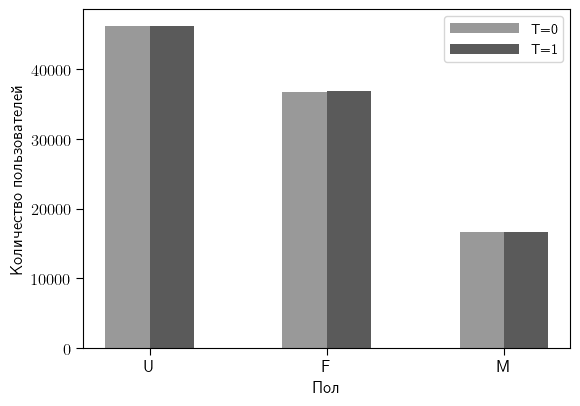

In [7]:
values = dict()

fig, ax = plt.subplots(figsize=(max_width, max_width*0.7))

for gender in df.gender.unique():
    values[gender] = [
        df[(df.treatment_flg == 0) & (df.gender == gender)].shape[0],
        df[(df.treatment_flg == 1) & (df.gender == gender)].shape[0]
    ]

genders = df.gender.unique()
X = np.arange(3)
width = 0.25
colors = ['#999999', '#5a5a5a']

for i in range(2):
    ax.bar(X+width*i, [values[g][i] for g in genders], label=f"T={i}", width=width, color=colors[i])
    
ax.set_xticks(X+0.125)
ax.set_xticklabels(genders.tolist())
ax.legend()
ax.set_xlabel("Пол")
ax.set_ylabel("Количество пользователей")
fig.savefig(f"{graphics_path}/gender_barplot.png", dpi=300, transparent=True)

### Age

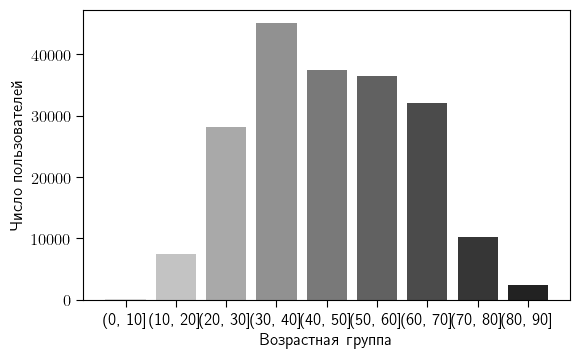

In [8]:
age_groups = pd.cut(df.age, bins=list(range(0, 100, 10))).to_frame().age.value_counts().sort_index()

fig, ax = plt.subplots(figsize=(max_width, max_width*0.6))
ax.bar(age_groups.index.map(str), 
       age_groups.values, 
       color=['#dddddd', '#c3c3c3', '#a9a9a9', '#919191', '#797979', '#616161', '#4b4b4b', '#363636', '#222222'])
ax.set_ylabel("Число пользователей")
ax.set_xlabel("Возрастная группа")

fig.savefig(f"{graphics_path}/age_barplot.png", dpi=300, transparent=True)

### Распределение средних чеков покупателей

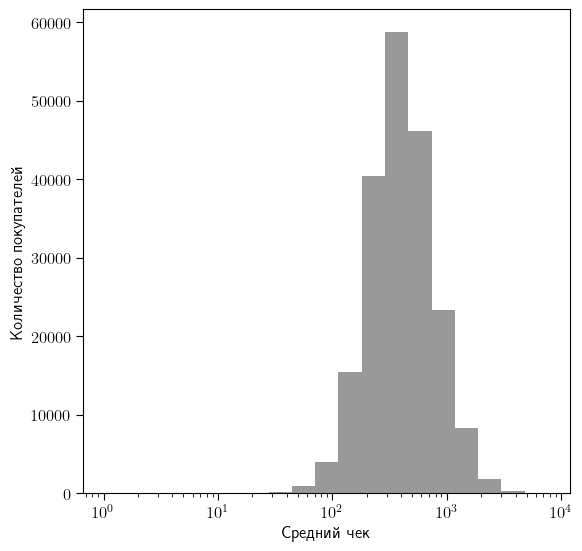

In [9]:
x = df.purchase_sum_mean

fig, ax = plt.subplots(figsize=(max_width, max_width))
logbins = np.geomspace(x.min(), x.max(), 20)
ax.hist(x, bins=logbins, color="#999999")
ax.set_xlabel("Средний чек")
ax.set_ylabel("Количество покупателей")
ax.set_xscale("log")

fig.savefig(f"{graphics_path}/mean_user_cheque.png", dpi=300, transparent=True)

## Classifier Two sample test

In [35]:
df.treatment_flg.sum(), df.shape

(99683, (199448, 55))

In [10]:
from dataclasses import dataclass

@dataclass
class TestData:
    losses: list
    emp_losses: list
        
    @classmethod
    def from_pickle(cls, path):
        with open(path, "rb") as f:
            test_data = pickle.load(f)
        
        return cls(**test_data)
    
test = TestData.from_pickle("../../data/c2st_results.pickle")

In [11]:
from scipy import stats

stats.ks_2samp(test.losses, test.emp_losses)

Ks_2sampResult(statistic=0.978, pvalue=0.0)

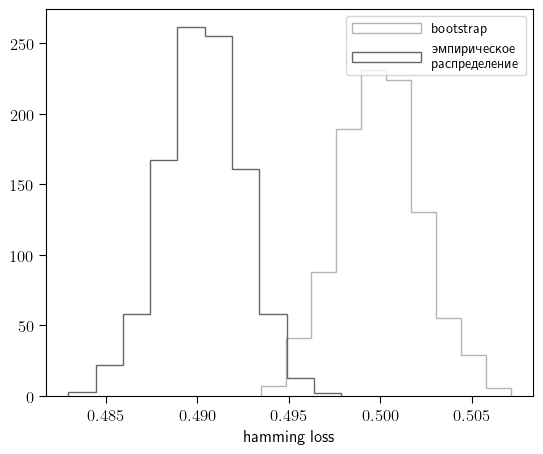

In [12]:
fig, ax = plt.subplots(figsize=(max_width, max_width*0.8))

ax.hist(test.losses, color="#b4b4b4", histtype="step", label="bootstrap")
ax.hist(test.emp_losses, color="#666666", histtype="step", label="эмпирическое\nраспределение")

ax.set_xlabel("hamming loss")
ax.legend()
fig.savefig(f"{graphics_path}/c2st.png", dpi=300, transparent=True)

## Graph

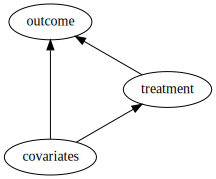

In [32]:
from graphviz import Digraph, Graph
import graphviz

dot = Digraph(engine='circo')
dot.attr()

dot.node('X', label='covariates')
dot.node('Y', label='outcome')
dot.node('T', label='treatment')

dot.edge('X', 'T')
dot.edge('X', 'Y')
dot.edge('T', 'Y')

dot.render("confound", directory="../../../master-thesis-text/graphics/", format="png", cleanup=True)
dot

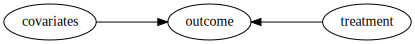

In [33]:
dot = Digraph(engine='circo')
dot.attr()

dot.node('X', label='covariates')
dot.node('Y', label='outcome')
dot.node('T', label='treatment')

# dot.edge('X', 'T')
dot.edge('X', 'Y')
dot.edge('T', 'Y')

dot.render("unconfound", directory="../../../master-thesis-text/graphics/", format="png", cleanup=True)
dot